# Evalutation results for DBpedia

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def plot_macro_f1(languages: set, f1_scores: dict, x_distance, figsize):
    x = np.arange(len(languages)) * x_distance  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)

    for attribute, measurement in f1_scores.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, fmt='%.2f')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by languages')
    ax.set_xticks(x + width*(len(f1_scores)-1)/2, languages)
    ax.legend(loc='upper left', ncols=3)
    plt.show()


def get_lang_set(results):
    languages_list = [set(result["Language"].tolist())
                      for result in results.values()]
    return set().union(*languages_list)


def get_f1_scores(results, languages):
    f1_scores = {}
    for name, result_df in results.items():
        scores = list()
        for lang in languages:
            try:
                macro_f1 = result_df.loc[result_df["Language"]
                                         == lang, "Macro F1"].iloc[0]
            except:
                macro_f1 = 0
            scores.append(macro_f1)
        f1_scores[name] = scores
    return f1_scores

def plot(results, x_distance=1, figsize=(8, 8)):
    languages = get_lang_set(results)
    f1_scores = get_f1_scores(results, languages)
    plot_macro_f1(languages, f1_scores, x_distance, figsize)

## Previous results

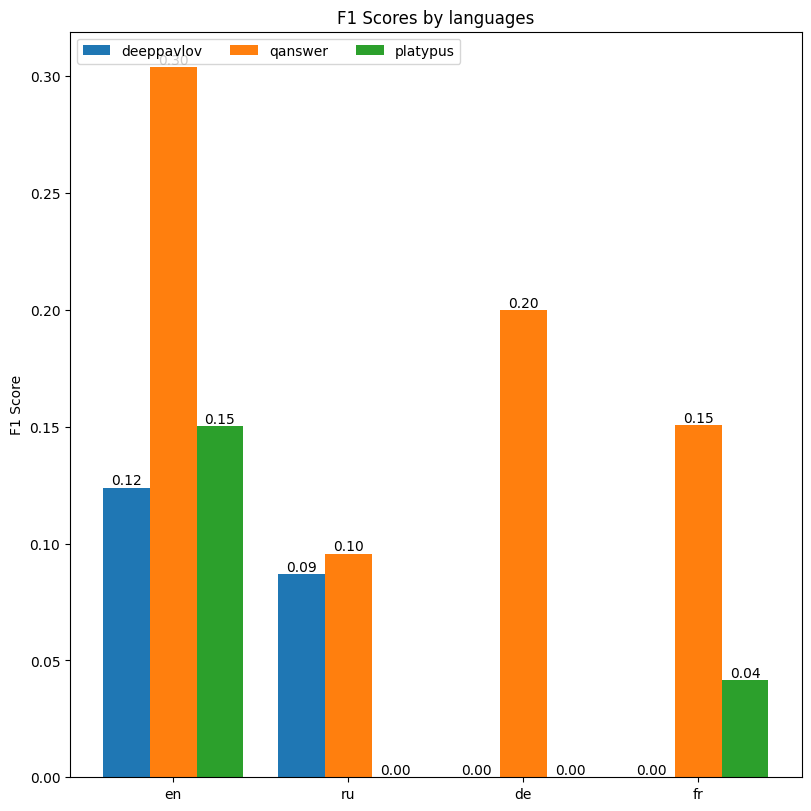

In [13]:
deeppavlov = pd.read_csv("../previous_paper_results/DeepPavlov_dbpedia.csv")
qanswer = pd.read_csv("../previous_paper_results/QAnswer_dbpedia.csv")
platypus = pd.read_csv("../previous_paper_results/Platypus_dbpedia.csv")
plot({
    "deeppavlov": deeppavlov,
    "qanswer": qanswer,
    "platypus": platypus
}, x_distance=1.5)

## Baseline

First, we only fine-tuned mT5-base model on qald-9-plus with DBpedia SPARQLs for 100 epochs as our baseline. 

**Keypoints**:

- without pre-training
- fine-tune on qald-9-plus
    - train for 100 epochs (as for Wikidata)
    - use all languages

In [14]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306270001
baseline = pd.read_csv("../gerbil_results/baseline-mt5base-qald9-dbp.csv")
baseline

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0633,0.1472,0.0404,0.2901,0.2930,0.2997,0.4436
1,be,0.1366,0.3255,0.0864,0.3670,0.3652,0.3813,0.5045
2,de,0.0439,0.0288,0.0922,0.3727,0.3709,0.3887,0.5183
3,en,0.0313,0.0204,0.0680,0.3352,0.3333,0.3534,0.4864
4,fr,0.0345,0.4423,0.0180,0.2558,0.2564,0.2553,0.4036
5,lt,0.0390,0.0255,0.0831,0.3435,0.3419,0.3600,0.5007
6,ru,0.0336,0.0221,0.0700,0.3484,0.3465,0.3697,0.5043
7,uk,0.0695,0.0641,0.0760,0.3748,0.3725,0.3935,0.5244


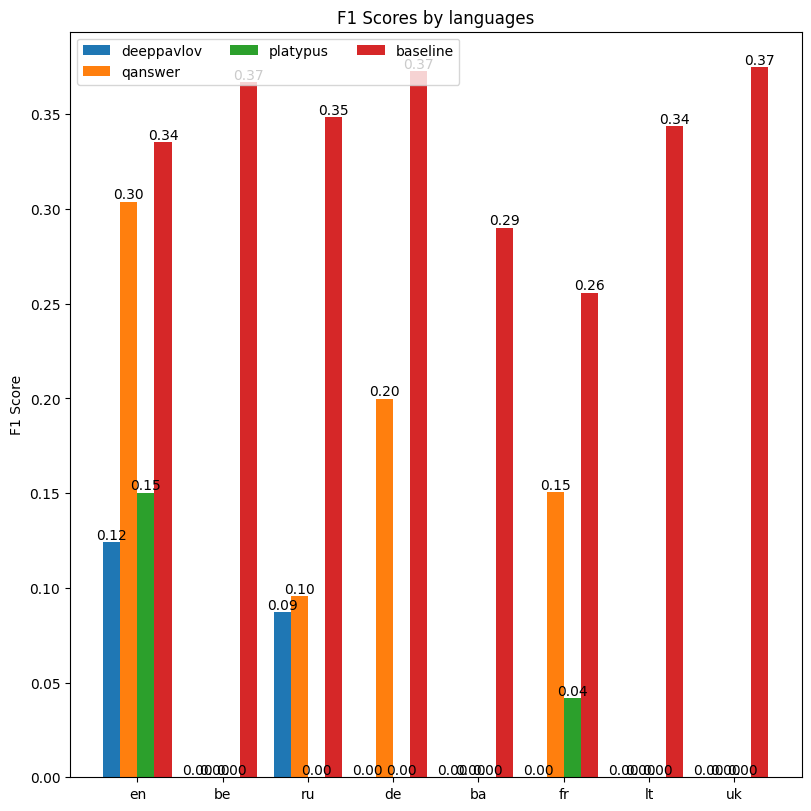

In [15]:
plot({
    "deeppavlov": deeppavlov,
    "qanswer": qanswer,
    "platypus": platypus,
    "baseline": baseline
}, x_distance=2)

Superisingly, our baseline results already exceed other systems. However, it could caused by some SPARQLs are not available now anymore. Even our system doesn't generate the correct SPARQL, it will still get a high F1 score for the questions in the reference data set, which also don't have any answer.

## Experiment 10

According to the experience from experiment for Wikidata, we first pre-trained on LCquad 1.0 (about 4000 samples) and fine-tuned on qald-9-plus with all language questions DBpedia SPARQLs.

**Keypoints**:

- pre-train on LC-QuAD 1.0
    - train for 15 epochs
    - with linguistic context and entity knowledge
- fine-tune on qald-9-plus
    - train for 15 epochs
    - use all languages
    - with linguistic context and entity knowledge 

Since our entity linking tool for DBpedia only works for `en`, `de`, and `fr`, we only evaluated our model on these languages. 

In [16]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306300002
exp10 = pd.read_csv("../gerbil_results/exp10-mt5xl-lcquad1-lc-et-dbp.csv")
exp10

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,de,0.0139,0.0077,0.0693,0.3531,0.3513,0.3694,0.5165
1,en,0.0469,0.0282,0.1397,0.3813,0.3938,0.3863,0.5211
2,fr,0.0147,0.0118,0.0194,0.2400,0.2400,0.2465,0.3939


Also from the previous experiments, the results could be better when the langauge model is fine-tuned on less langauges. Therefore, we fine-tuned our model again on qald-9-plus with only `en`, `de`, and `fr`, which are supported by our entity linker, and DBpedia SPARQL. 

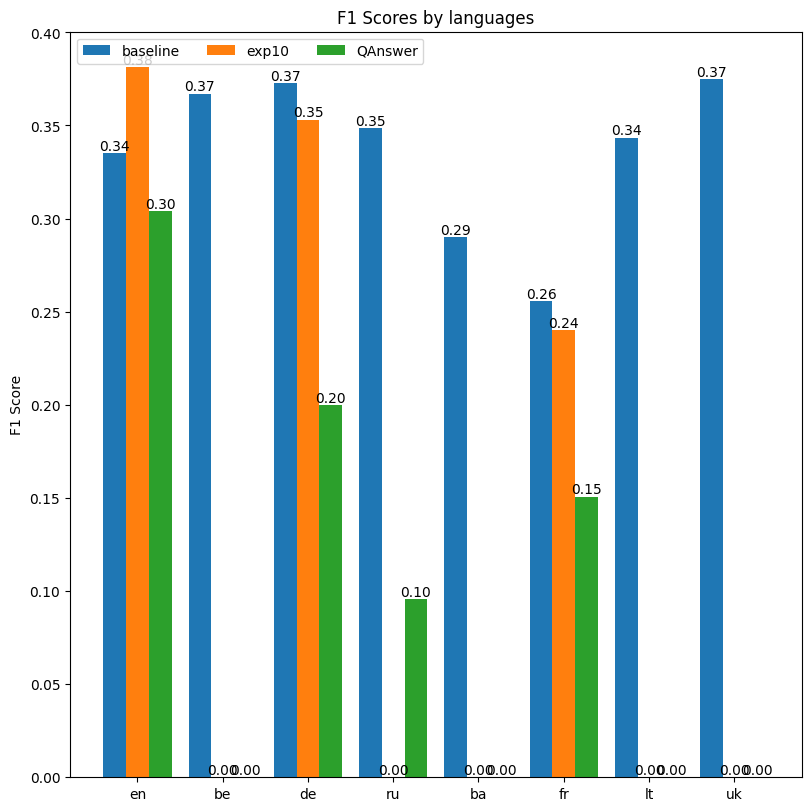

In [17]:
plot({
    "baseline": baseline,
    "exp10": exp10,
    "QAnswer": qanswer
}, x_distance=1.5)

However, there are no much difference between baseline and exp10.

In [18]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202307010000
exp10_endefr = pd.read_csv("../gerbil_results/exp10-mt5xl-lcquad1-lc-et-dbp-endefr.csv")
exp10_endefr

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,de,0.0102,0.0056,0.0604,0.3726,0.3706,0.3835,0.5234
1,en,0.2262,0.6820,0.1356,0.4249,0.4336,0.4247,0.5597
2,fr,0.0246,0.9783,0.0125,0.2533,0.2533,0.2532,0.4035


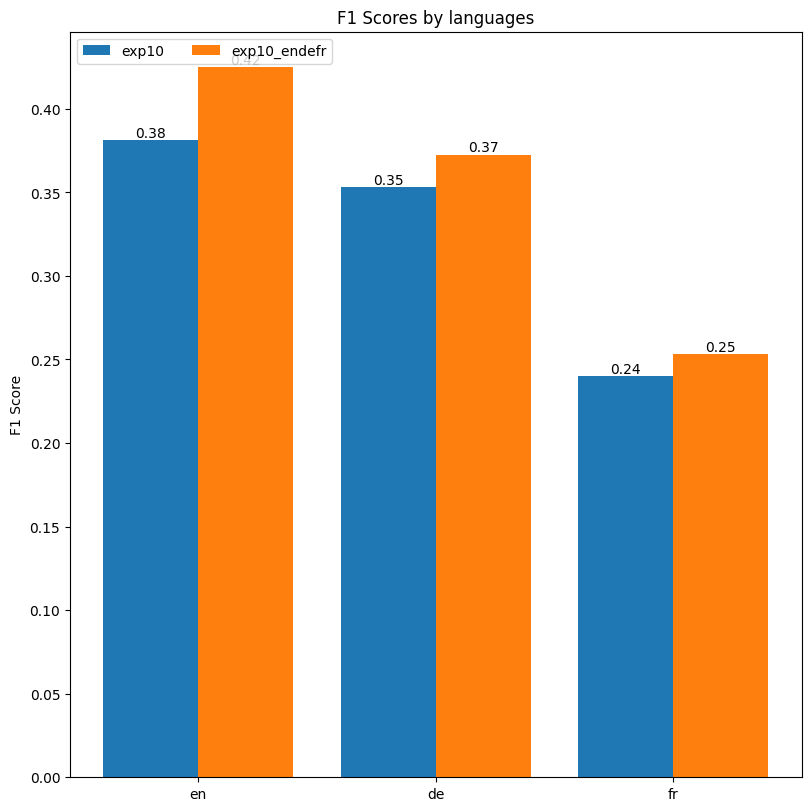

In [19]:
plot({
    "exp10": exp10,
    "exp10_endefr": exp10_endefr
})

The performance is better when we train it on fewer languages.

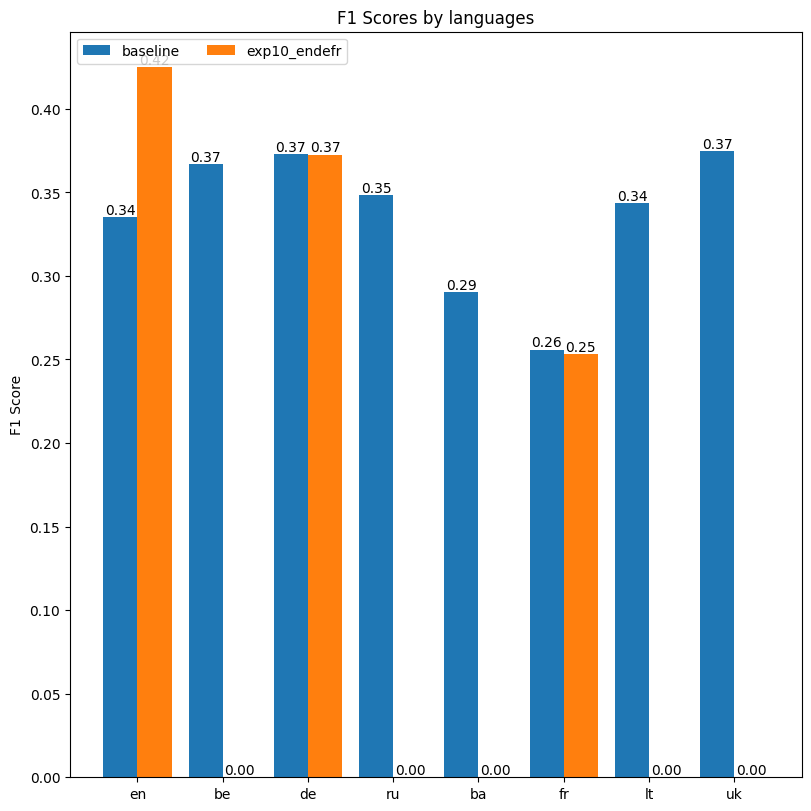

In [20]:
plot({
    "baseline": baseline,
    "exp10_endefr": exp10_endefr
})

Now, `de` and `fr` are almost the same as for baseline, and exp10_endefr performs significantly better than our baseline in `en`.

Reasons for average performance in `de` and `fr` could be the accuracy of Entity linking. 

## Experiment 11

In this experiment, we simulated a situation that no entity linker available. 
There is no available entity linker for any language other than `en`, `de`, and `fr`, therefore, in experiment 11, we are able to fine-tune and evaluate on all languages in qald-9-plus. 

We used the same pre-trained model in experiment 10, and excluded entity knowledge from fine-tuning data set. 
All languages in qald-9-plus are included in our fine-tuning data set.

**Keypoints**:

- pre-train on LC-QuAD
    - train for 15 epochs
    - with linguistic context and entity knowledge
- fine-tune on qald-9-plus
    - train for 15 epochs
    - use all languages
    - with linguistic context

In [21]:
exp11 = pd.read_csv("../gerbil_results/exp11-mt5xl-lcquad1-lc-ptet-dbp.csv")
exp11

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0245,0.0146,0.0773,0.3051,0.3070,0.3233,0.4699
1,be,0.0554,0.0327,0.1805,0.4219,0.4331,0.4340,0.5675
2,de,0.1152,0.0792,0.2107,0.4449,0.4511,0.4625,0.5993
3,en,0.0828,0.0528,0.1916,0.4655,0.4694,0.4936,0.6208
4,es,0.1049,0.0721,0.1924,0.4543,0.4644,0.4726,0.5972
5,fr,0.0449,0.9022,0.0230,0.2666,0.2667,0.2665,0.4191
6,ja,0.1001,0.0686,0.1855,0.4386,0.4445,0.4561,0.5873
7,lt,0.0848,0.0546,0.1905,0.4227,0.4337,0.4340,0.5739
8,ru,0.1287,0.0978,0.1882,0.4165,0.4194,0.4336,0.5639
9,uk,0.0499,0.0287,0.1902,0.4196,0.4288,0.4387,0.5655


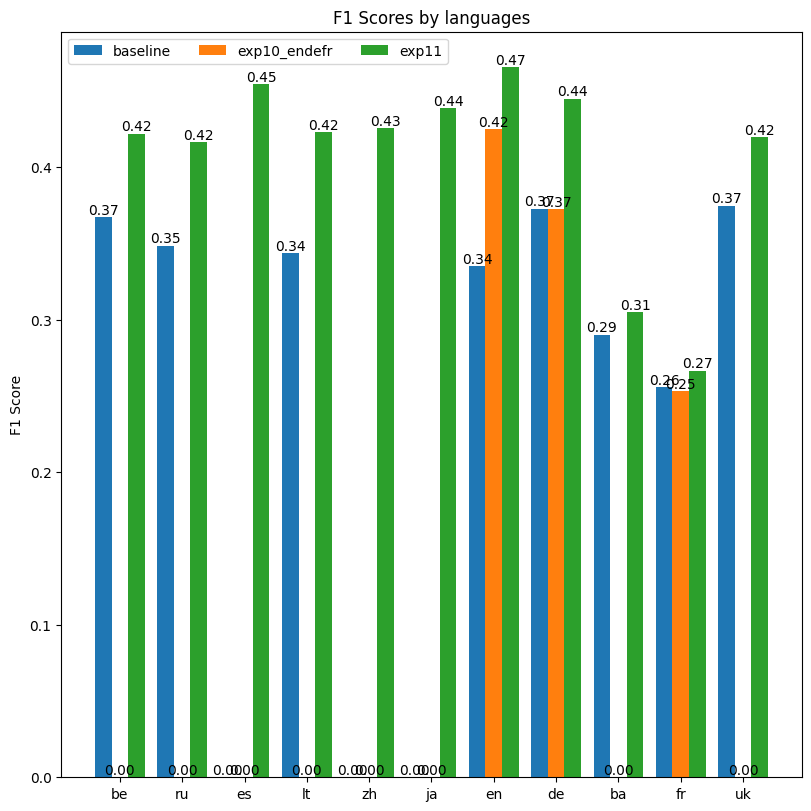

In [22]:
plot({
    "baseline": baseline,
    "exp10_endefr": exp10_endefr,
    "exp11": exp11
}, x_distance=1.5)

According to the chart, experiment 11 performs the best in all languages. 

Comparing baseline and exp10_endefr, the exp10_endefr only performs better in English, the reason for it could be that the entity linker doesn't give the correct entities for some questions. Moreover, the entity linker always tries to give the entity uri in the same language as the question language. It could happen that the entity is available in English, but not in other langauges. Thus, providing entity knowledge from entity linking is not very reliable for other languages besides English. 

Now in Experiment 11, we did not add entity knowledge in fine-tuning and inference, but let the language model learn the entity knowledge by itself. With this ability from the language model, the results are the best and this model supports more languages.

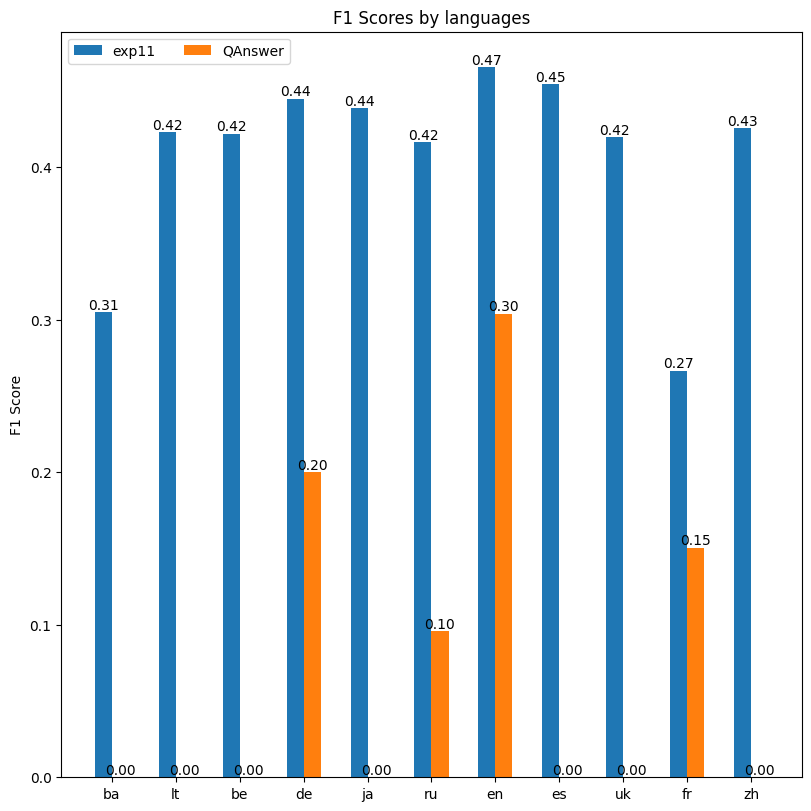

In [14]:
plot({
    "exp11": exp11,
    "QAnswer": qanswer
}, x_distance=1.5)

Compare to QAnswer, our results is significantly better again. 

## Experiment 12

As we did in experiment 9 for Wikidata, we also want to know **the effect of adding entity knowledge** to input questions. 
We only added linguistic context to the input string to see the effect of it. 

Later we will compare it with experiment 11 to see the effect of adding entity knowledge. 

In [23]:
exp12 = pd.read_csv("../gerbil_results/exp12-mt5xl-lcquad1-lc-dbp.csv")
exp12

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0220,0.0131,0.0696,0.2984,0.2995,0.3102,0.4578
1,be,0.1283,0.1100,0.1539,0.4337,0.4410,0.4492,0.5904
2,de,0.0774,0.0525,0.1467,0.4451,0.4489,0.4714,0.6010
3,en,0.1394,0.1036,0.2129,0.4715,0.4747,0.4961,0.6242
4,es,0.0588,0.0366,0.1489,0.4438,0.4547,0.4753,0.6057
5,fr,0.0449,0.9022,0.0230,0.2666,0.2667,0.2665,0.4191
6,ja,0.0972,0.0616,0.2304,0.4185,0.4249,0.4354,0.5601
7,lt,0.0479,0.0292,0.1325,0.4332,0.4391,0.4551,0.5934
8,ru,0.0657,0.0429,0.1397,0.4214,0.4268,0.4381,0.5759
9,uk,0.0519,0.0317,0.1444,0.4393,0.4493,0.4719,0.5979


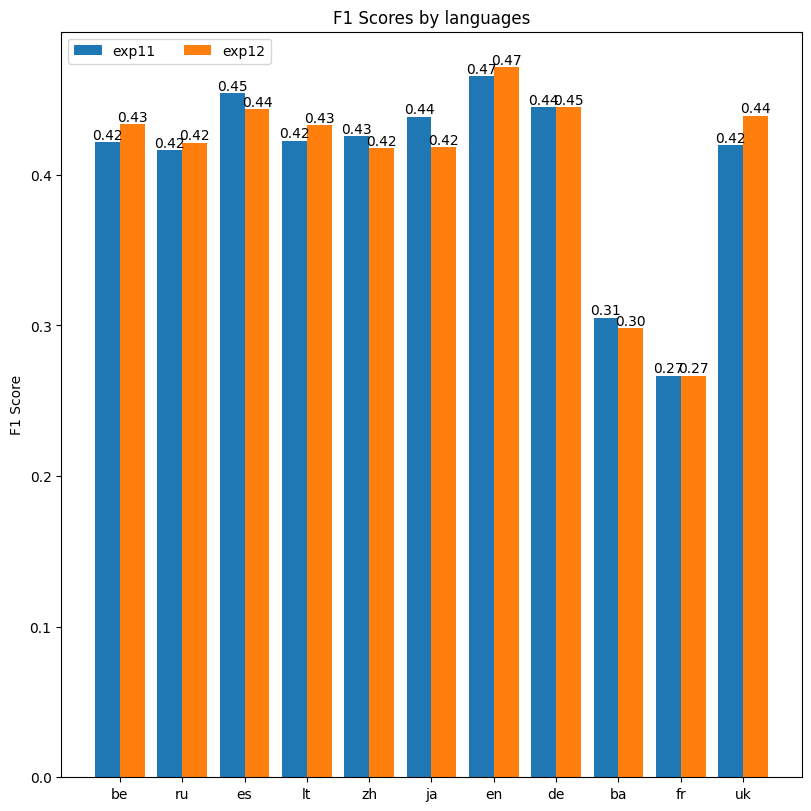

In [25]:
plot({
    "exp11": exp11,
    "exp12": exp12
})

The results from exp11 and exp12 are very close. exp12 performs a little better in some languages and a little worse in others, but the overall difference is not large.

We can infer that adding entity knowledge to the input strings doesn't have a huge impact for DBpedia. 
This could be related to the representation of entities and relations in DBpedia SPARQLs. 
Not like in Wikidata, the entities and relations are represented in letter + number, the representations are real words. If the tokenizer tokenizes an entity or a relation to subwords, the language model already has some knowledge about the entity or the relation. 